In [ ]:
from utils import Plot
Plot(his)

In [ ]:
from utils import segmentation_inference
model = torch.load("saved_models/cells_best_model.pt")
segmentation_inference(test_dl, model=model)

In [7]:
%load_ext autoreload
%autoreload 2

import torch
from get_transforms import RandomHorizontalFlip, ConvertImageDtype, PILToTensor, Compose
from utils import tensor_2_im
from torch.utils.data import random_split, Dataset, DataLoader

from glob import glob
from PIL import Image
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
class ObjectDetectionCustomDataset(Dataset):
    
    def __init__(self, root, transformations, im_files = [".jpg", ".png", ".jpeg"]):
        
        self.root, self.transformations = root, transformations
        
        self.im_paths = sorted(glob(f"{root}/PNGImages/*[{im_file for im_file in im_files}]"))
        self.gt_paths = sorted(glob(f"{root}/PedMasks/*[{im_file for im_file in im_files}]"))

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        # GT mask ni RGB ga o'tkazmaganimizning sababi GT  dagi har bir rang bir klass ga tegishli, shuning uchun uning ranglariga tegilmaydi.
        im, gt = Image.open(self.im_paths[idx]).convert("RGB"), np.array(Image.open(self.gt_paths[idx]))
        
        # instances are encoded as different colors
        # 0 klass background bo'lgani uchun uni olib tashlaymiz.
        obj_indekslari = np.unique(gt)[1:]

        # split the color-encoded mask into a set
        # of binary masks
        gts = gt == obj_indekslari[:, None, None]
        

        # get bounding box coordinates for each mask
        obj_soni = len(obj_indekslari)
        
        boxes = []
        for i, box in enumerate(gts):
            pos = np.where(box)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        # there is only one class
        labels = torch.ones((obj_soni,), dtype = torch.int64)
        gts = torch.as_tensor(gts, dtype = torch.uint8)
        
        im_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((obj_soni,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = gts
        target["image_id"] = im_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transformations is not None: im, target = self.transformations(im, target)
        # cv2.imwrite(f'/home/ubuntu/workspace/bekhzod/dl_class/object_detection/image_{idx}_mask.png', tensor_2_im(gts))
        # cv2.imwrite(f'image_{idx}_img.png', tensor_2_im(im))

        return im, target

In [9]:
transformations = Compose([PILToTensor(), ConvertImageDtype(torch.float)])
ds = ObjectDetectionCustomDataset("/home/ubuntu/workspace/bekhzod/aic/object_detection/data/", transformations)
ds[22]

(tensor([[[0.1882, 0.2196, 0.1373,  ..., 0.4784, 0.4745, 0.4863],
          [0.1843, 0.2235, 0.1529,  ..., 0.4745, 0.4745, 0.4745],
          [0.1882, 0.2039, 0.1059,  ..., 0.4941, 0.4941, 0.4784],
          ...,
          [0.6667, 0.6667, 0.6667,  ..., 0.5216, 0.5255, 0.5255],
          [0.6549, 0.6588, 0.6627,  ..., 0.5333, 0.5255, 0.5255],
          [0.6471, 0.6510, 0.6549,  ..., 0.5333, 0.5255, 0.5255]],
 
         [[0.2196, 0.2510, 0.1765,  ..., 0.5451, 0.5373, 0.5490],
          [0.2157, 0.2549, 0.1922,  ..., 0.5373, 0.5373, 0.5373],
          [0.2196, 0.2353, 0.1451,  ..., 0.5569, 0.5569, 0.5412],
          ...,
          [0.6157, 0.6157, 0.6157,  ..., 0.5216, 0.5255, 0.5255],
          [0.6039, 0.6078, 0.6118,  ..., 0.5333, 0.5255, 0.5255],
          [0.5961, 0.6000, 0.6039,  ..., 0.5333, 0.5255, 0.5255]],
 
         [[0.1255, 0.1569, 0.0784,  ..., 0.4824, 0.4941, 0.5059],
          [0.1255, 0.1608, 0.0941,  ..., 0.4863, 0.4941, 0.4941],
          [0.1373, 0.1451, 0.0471,  ...,

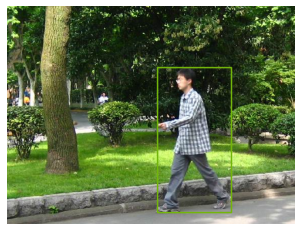

In [10]:
import cv2
from matplotlib import pyplot as plt

im, target = ds[30]
img = tensor_2_im(im)    
for i, cntr in enumerate(target["boxes"]):
    r, g, b = int(np.random.randint(0, 255, 1)), int(np.random.randint(0, 255, 1)), int(np.random.randint(0, 255, 1))
    x, y, w, h = [round(c.item()) for c in cntr]
    cv2.rectangle(img, (x, y), (w, h), (r, g, b), 2)
    plt.imshow(img)
    plt.axis("off")